# 提高神经网络性能

 **学习目标**：通过将特征标准化并应用各种优化算法来提高神经网络的性能

**注意**：本练习中介绍的优化方法并非专门针对神经网络；这些方法可有效改进大多数类型的模型。

## 设置

In [1]:
%matplotlib inline
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [2]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

In [3]:
# 训练集
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# 验证集
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2633.2,539.5,1425.5,501.3,3.9,2.0
std,2.1,2.0,12.5,2160.2,422.0,1118.1,385.2,1.9,1.2
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1464.8,298.0,792.0,282.0,2.6,1.5
50%,34.3,-118.5,29.0,2126.5,435.0,1165.5,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3137.0,647.0,1719.2,604.0,4.7,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.4,2668.7,539.2,1439.2,501.0,3.9,2.0
std,2.1,2.0,12.7,2226.7,420.3,1216.3,382.8,2.0,1.2
min,32.5,-124.3,2.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1454.0,294.0,783.0,281.0,2.6,1.5
50%,34.2,-118.5,28.0,2131.0,431.0,1171.0,407.0,3.6,1.9
75%,37.7,-118.0,37.0,3190.5,651.2,1724.0,608.0,4.8,2.3
max,41.9,-114.5,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,206.6
std,115.7
min,17.5
25%,118.8
50%,179.8
75%,263.8
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,209.1
std,116.7
min,15.0
25%,121.4
50%,181.8
75%,267.6
max,500.0


## 训练神经网络

In [4]:
def construct_feature_columns(input_features):
    
    return set([tf.feature_column.numeric_column(my_feature) 
                for my_feature in input_features])

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [14]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    
    periods = 10
    steps_per_period = steps / periods

    # Create a nn regressor object.
    # my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=my_optimizer
    )

    # 1. Create input functions.
    training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value"], 
        batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value"], 
        num_epochs=1, 
        shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples,
        validation_targets["median_house_value"], 
        num_epochs=1, 
        shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
        # 2. Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 148.15
  period 01 : 144.19
  period 02 : 132.32
  period 03 : 112.86
  period 04 : 109.47
  period 05 : 105.87
  period 06 : 111.75
  period 07 : 104.38
  period 08 : 106.12
  period 09 : 103.48
Model training finished.
Final RMSE (on training data):   103.48
Final RMSE (on validation data): 106.14


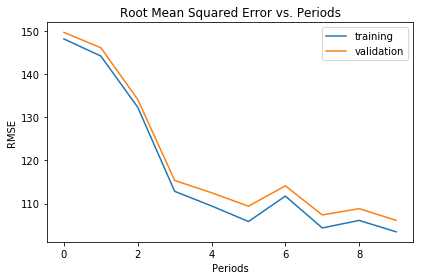

In [10]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## 线性缩放特征

**将输入标准化到 (-1, 1) 这一范围内。**

将输入标准化以使其位于 (-1, 1) 范围内可能是一种良好的标准做法。这样一来，SGD 在一个维度中采用很大步长（或者在另一维度中采用很小步长）时不会受阻。这种做法与使用预调节器 (Preconditioner) 的想法是有联系的。

In [11]:
def linear_scale(series):
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val) / 2.0
    return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [12]:
def normalize_linear_scale(examples_dataframe):
    processed_features = pd.DataFrame()
    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
    processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
    processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
    processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
    processed_features["population"] = linear_scale(examples_dataframe["population"])
    processed_features["households"] = linear_scale(examples_dataframe["households"])
    processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
    processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
    return processed_features

Training model...
RMSE (on training data):
  period 00 : 176.11
  period 01 : 114.48
  period 02 : 103.46
  period 03 : 87.35
  period 04 : 78.45
  period 05 : 75.32
  period 06 : 73.62
  period 07 : 72.34
  period 08 : 71.89
  period 09 : 70.94
Model training finished.
Final RMSE (on training data):   70.94
Final RMSE (on validation data): 70.23


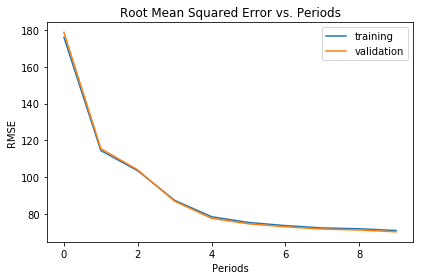

In [13]:
normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

## AdaGrad 和 Adam 优化器

AdaGrad 优化器是一种备选方案。AdaGrad 的核心是灵活地修改模型中每个系数的学习率，从而单调降低有效的学习率。该优化器对于凸优化问题非常有效，但不一定适合非凸优化问题的神经网络训练。可以通过指定 AdagradOptimizer（而不是 GradientDescentOptimizer）来使用 AdaGrad。请注意，对于 AdaGrad，需要使用较大的学习率。

对于非凸优化问题，Adam 有时比 AdaGrad 更有效。要使用 Adam，请调用 tf.train.AdamOptimizer 方法。此方法将几个可选超参数作为参数，但我们的解决方案仅指定其中一个 (learning_rate)。在应用设置中，应该谨慎指定和调整可选超参数。

Training model...
RMSE (on training data):
  period 00 : 80.52
  period 01 : 72.91
  period 02 : 74.14
  period 03 : 71.76
  period 04 : 72.47
  period 05 : 70.32
  period 06 : 70.39
  period 07 : 69.54
  period 08 : 69.24
  period 09 : 69.26
Model training finished.
Final RMSE (on training data):   69.26
Final RMSE (on validation data): 68.22


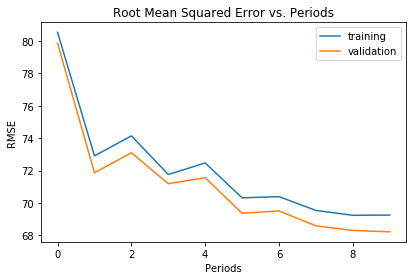

In [15]:
# AdaGrad
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 206.07
  period 01 : 121.16
  period 02 : 113.07
  period 03 : 100.07
  period 04 : 86.43
  period 05 : 75.16
  period 06 : 72.79
  period 07 : 72.03
  period 08 : 70.87
  period 09 : 70.13
Model training finished.
Final RMSE (on training data):   70.13
Final RMSE (on validation data): 69.28


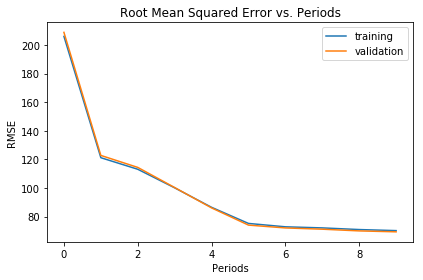

In [16]:
# Adam
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

并排输出损失指标的图表

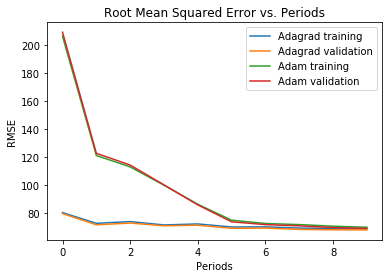

In [17]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

## 其他标准化方法

尝试对各种特征使用其他标准化方法，以进一步提高性能。

如果仔细查看转换后数据的汇总统计信息，会发现，对某些特征进行线性缩放会使其聚集到接近 -1 的位置。

例如，很多特征的中位数约为 -0.8，而不是 0.0。

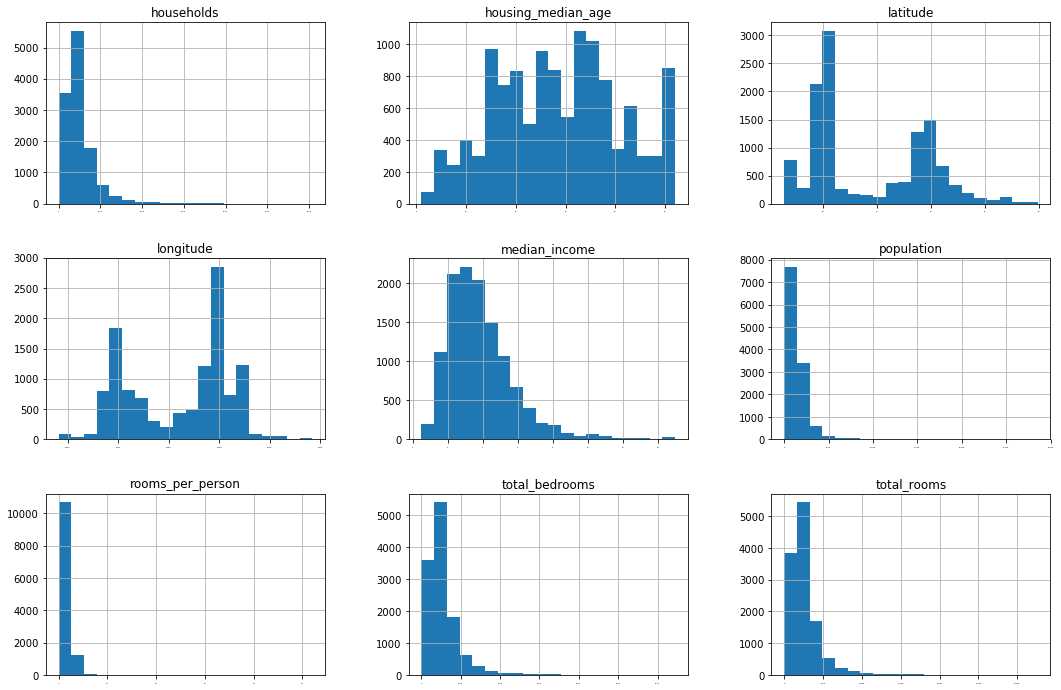

In [19]:
_ = training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=2)

 通过选择其他方式来转换这些特征，我们可能会获得更好的效果。

In [20]:
def log_normalize(series):
    return series.apply(lambda x: math.log(x + 1.0))

def clip(series, clip_to_min, clip_to_max):
    return series.apply(lambda x: (
        min(max(x, clip_to_min), clip_to_max)))

def z_score_normalizes(series):
    mean = series.mean()
    std_dv = series.std()
    return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
    return series.apply(lambda x:(1 if x > threshold else 0))

households、median_income 和 total_bedrooms 在对数空间内均呈现为正态分布。

如果 latitude、longitude 和 housing_median_age 像之前一样进行线性缩放，效果可能会更好。

population、totalRooms 和 rooms_per_person 具有几个极端离群值。这些值似乎过于极端，以至于我们无法利用对数标准化处理这些离群值。因此，我们直接截取掉这些值。

Training model...
RMSE (on training data):
  period 00 : 107.20
  period 01 : 80.73
  period 02 : 75.12
  period 03 : 72.60
  period 04 : 71.59
  period 05 : 70.91
  period 06 : 70.57
  period 07 : 69.95
  period 08 : 69.95
  period 09 : 69.30
Model training finished.
Final RMSE (on training data):   69.30
Final RMSE (on validation data): 68.33


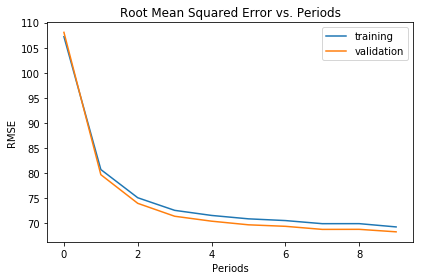

In [21]:
def normalize(examples_dataframe):
    processed_features = pd.DataFrame()

    processed_features["households"] = log_normalize(examples_dataframe["households"])
    processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
    processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])

    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
    processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

    processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
    processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
    processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

    return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ## 可选挑战：仅使用纬度和经度特征

**训练仅使用纬度和经度作为特征的神经网络模型。**

房地产商喜欢说，地段是房价的唯一重要特征。
我们来看看能否通过训练仅使用纬度和经度作为特征的模型来证实这一点。

只有我们的神经网络模型可以从纬度和经度中学会复杂的非线性规律，才能达到我们想要的效果。

**注意**：我们可能需要一个网络结构，其层数比我们之前在练习中使用的要多。

Training model...
RMSE (on training data):
  period 00 : 104.84
  period 01 : 102.41
  period 02 : 101.41
  period 03 : 100.57
  period 04 : 99.64
  period 05 : 99.34
  period 06 : 98.92
  period 07 : 98.77
  period 08 : 98.57
  period 09 : 98.33
Model training finished.
Final RMSE (on training data):   98.33
Final RMSE (on validation data): 99.01


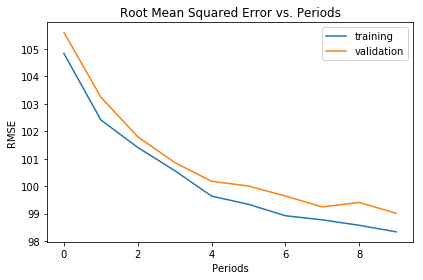

In [22]:
def location_location_location(examples_dataframe):
    processed_features = pd.DataFrame()
    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
    return processed_features

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)

对于只有两个特征的模型，结果并不算太糟。当然，地产价值在短距离内仍然可能有较大差异。